In [181]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [8]:
%matplotlib inline

In [201]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx],idx

## Load data

In [104]:
# Read in data
X_train = pd.read_csv("../data/scaled_X_train.csv")
y_train = pd.read_csv("../data/scaled_y_train.csv")
X_test = pd.read_csv("../data/scaled_X_test.csv")
y_test = pd.read_csv("../data/scaled_y_test.csv")

# exclude the year column
X_train = X_train.drop(columns = "year")
X_test = X_test.drop(columns = "year")

X_train.head()

,democrat_perc,AvgSalary,PerCapNetEarning,PerCapNetIncome,TotalNumJobs,Sale_Prices,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore
0,1.187014,1.023277,0.984646,0.850506,0.178410,1.221901,-0.004104,-0.036893,0.021631,0.023977,-0.025684
1,1.199637,0.023937,-0.383640,-0.462143,-0.750147,-0.009682,0.026937,0.080594,0.070108,-0.025834,-0.083322
2,-0.572699,-1.057257,-1.294860,-1.396147,-0.280227,-1.590602,-0.473441,-0.440902,-0.402933,-0.376713,-0.337893
3,0.833619,0.072848,0.041553,-0.012319,0.112448,0.760825,-0.216729,-0.353839,-0.324579,-0.287681,-0.215065
4,0.756480,-0.606384,-0.832131,-0.890741,-0.309058,0.428678,-0.623486,-0.444504,-0.301532,-0.277814,-0.221680


## Build Lasso model with CV

In [172]:
# Initialize lasso model
a_list = [0.000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1] # lists of alpha value
lasso_cv = LassoCV(n_alphas=len(a_list), alphas=a_list, cv=10, max_iter=100000,random_state=26).fit(X_train, y_train.values.ravel())

# lasso_cv = LassoCV(cv=10,max_iter=100000,random_state=26).fit(X_train,y_train.values.ravel())

# Store the mean cross-validation MSEs across each fold
lassoCV_val_mses_mean = lasso_cv.mse_path_
# Save the best 𝛼 based on the mean cross-validation MSE
best_alpha = lasso_cv.alpha_
best_alpha

1e-06

Text(0.5, 1.0, 'Coefficient value')

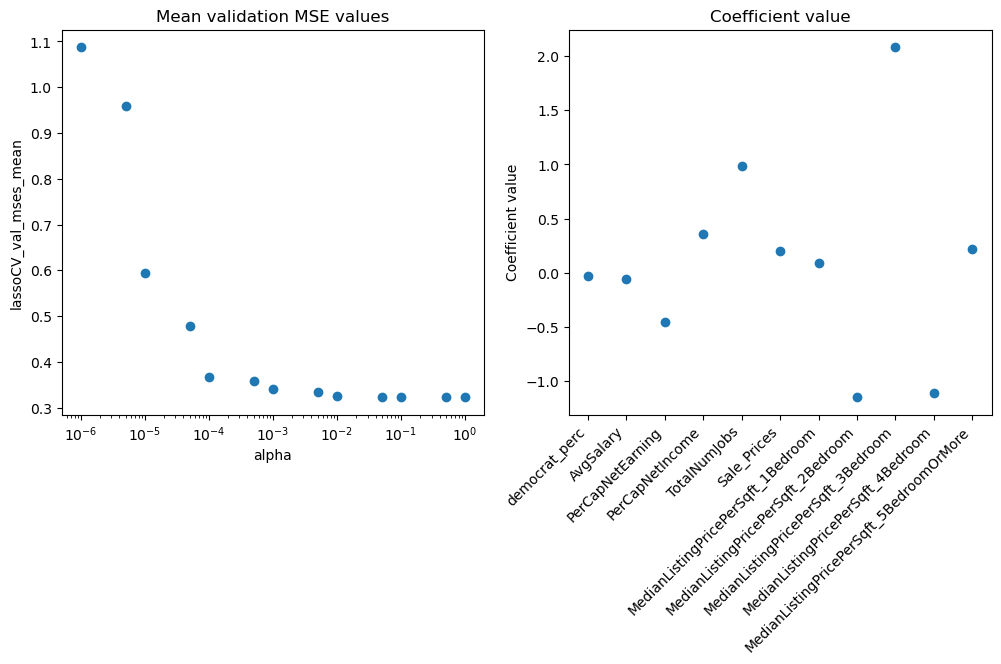

In [173]:
fig,axs = plt.subplots(1,2,figsize=(12, 5))

axs[0].scatter(a_list,np.mean(lassoCV_val_mses_mean,axis=1).tolist())
axs[0].set_xscale('log')
axs[0].set_xlabel('alpha')
axs[0].set_ylabel('lassoCV_val_mses_mean')
axs[0].set_title("Mean validation MSE values")

axs[1].scatter(np.linspace(1,lasso_cv.coef_.shape[0],lasso_cv.coef_.shape[0]),lasso_cv.coef_)
axs[1].set_xticks(np.arange(1,lasso_cv.coef_.shape[0]+1))
axs[1].set_xticklabels(X_train.columns, rotation=45, ha='right')
axs[1].set_ylabel('Coefficient value')
axs[1].set_title("Coefficient value")

In [174]:
# Make predictions
y_train_predict = lasso_cv.predict(X_train)
y_test_predict = lasso_cv.predict(X_test)
train_mse = mean_squared_error(y_train,y_train_predict)
test_mse = mean_squared_error(y_test,y_test_predict)

print("The train MSE for the lasso model is " + str(train_mse))
print("The test MSE for the lasso model is " + str(test_mse))

# Modal diagnostics
train_score = lasso_cv.score(X_train,y_train)
test_score = lasso_cv.score(X_test,y_test)

print("The train R2 for the lasso model is " + str(train_score))
print("The test R2 for the lasso model is " + str(test_score))

The train MSE for the lasso model is 0.10526153608890178
The test MSE for the lasso model is 0.392648454948463
The train R2 for the lasso model is 0.9020018719336064
The test R2 for the lasso model is 0.43637536851542347


The train and test MSE is small, but the R-squared values for test and training set differ a lot (test R2 is much lower comparing to training R2). Therefore, it seems like the model overfitted. 

## Decrease overfitting

In [224]:
corr_matrix = X_train.corr()
high_corr = {}

high_corr_mat = corr_matrix[corr_matrix[abs(corr_matrix)>= 0.95].notna()]
for i in range(high_corr_mat.shape[0]):
    for j in range(high_corr_mat.shape[1]):
        if not np.isnan(high_corr_mat.iloc[i,j]) and i != j:
            if i >= j:
                new_pair = {(high_corr_mat.columns[i],high_corr_mat.columns[j]): high_corr_mat.iloc[i,j]}
            else: 
                new_pair = {(high_corr_mat.columns[j],high_corr_mat.columns[i]): high_corr_mat.iloc[i,j]}
            high_corr.update(new_pair)

            
print("The following pairs of predictor variables have correlation greater than 0.95 or less than -0.95:")
display(high_corr)

The following pairs of predictor variables have correlation greater than 0.95 or less than -0.95:


{('PerCapNetIncome', 'PerCapNetEarning'): 0.9721387036981505,
 ('MedianListingPricePerSqft_2Bedroom',
  'MedianListingPricePerSqft_1Bedroom'): 0.971674690757072,
 ('MedianListingPricePerSqft_3Bedroom',
  'MedianListingPricePerSqft_1Bedroom'): 0.955745751157604,
 ('MedianListingPricePerSqft_3Bedroom',
  'MedianListingPricePerSqft_2Bedroom'): 0.9953721459389778,
 ('MedianListingPricePerSqft_4Bedroom',
  'MedianListingPricePerSqft_2Bedroom'): 0.9873771771268126,
 ('MedianListingPricePerSqft_5BedroomOrMore',
  'MedianListingPricePerSqft_2Bedroom'): 0.962154323671749,
 ('MedianListingPricePerSqft_4Bedroom',
  'MedianListingPricePerSqft_3Bedroom'): 0.9943276450364248,
 ('MedianListingPricePerSqft_5BedroomOrMore',
  'MedianListingPricePerSqft_3Bedroom'): 0.9669431068424044,
 ('MedianListingPricePerSqft_5BedroomOrMore',
  'MedianListingPricePerSqft_4Bedroom'): 0.9810106437907365}

It seems like the input data from Zillow is highly correlated. Therefore, we try to minize the effect of such correlation using either PCA, polynomial.

### PCA of input space

In [226]:
# Find the best k
val_mses_mean = []
val_r2_train = []
val_r2_test = []
k_list = [1,2,3,4,5,6,7,8,9,10,11]

for k in k_list:
    X_pca_train = PCA(n_components=k).fit_transform(X_train)
    X_pca_test = PCA(n_components=k).fit_transform(X_test)
    
    # Fit model
    lasso_pca = LassoCV(n_alphas=len(a_list), alphas=a_list, cv=10, max_iter=100000,random_state=26).fit(X_pca_train, y_train.values.ravel())
    # cv_results = cross_validate(linreg, X_pca_train, y_train_scaled, cv=10, scoring='neg_mean_squared_error', return_train_score=True)
    best_alpha_idx = find_nearest(a_list,lasso_pca.alpha_)[1]
    # print(find_nearest(a_list,lasso_pca.alpha_))
    val_mses_mean.append(lasso_pca.mse_path_[best_alpha_idx].mean())
    
    # Model diagnostics
    r2_train = lasso_pca.score(X_pca_train,y_train)
    r2_test = lasso_pca.score(X_pca_test,y_test)
    val_r2_train.append(r2_train)
    val_r2_test.append(r2_test)
    print("The train R2 for current lasso_pca model (k = " + str(k) + "): " + str(r2_train))
    print("The test R2 for current lasso_pca model (k = " + str(k) + "): " + str(r2_test))
    
best_k = k_list[val_mses_mean.index(min(val_mses_mean))]
print(f"The best k is {best_k}.")

The train R2 for current lasso_pca model (k = 1): 0.0
The test R2 for current lasso_pca model (k = 1): -0.024548181060703334
The train R2 for current lasso_pca model (k = 2): 0.15664460121824186
The test R2 for current lasso_pca model (k = 2): 0.37639750501468017
The train R2 for current lasso_pca model (k = 3): 0.7813649525044558
The test R2 for current lasso_pca model (k = 3): 0.34943166121256675
The train R2 for current lasso_pca model (k = 4): 0.8701652983101975
The test R2 for current lasso_pca model (k = 4): 0.183435125828614
The train R2 for current lasso_pca model (k = 5): 0.8780285510471235
The test R2 for current lasso_pca model (k = 5): 0.18692597723079474
The train R2 for current lasso_pca model (k = 6): 0.8795452739480535
The test R2 for current lasso_pca model (k = 6): 0.18841687872605728
The train R2 for current lasso_pca model (k = 7): 0.8832568624553919
The test R2 for current lasso_pca model (k = 7): 0.18152132941819332
The train R2 for current lasso_pca model (k = 8)

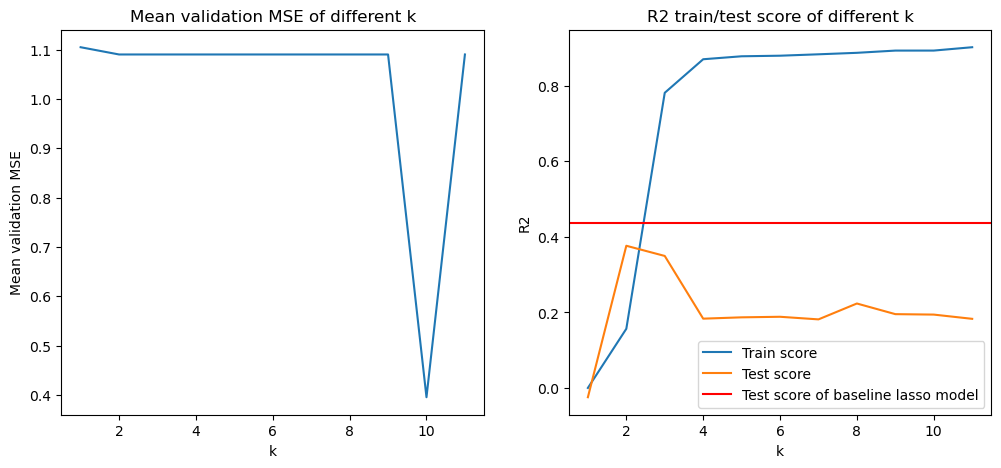

In [235]:
fig,axs = plt.subplots(1,2,figsize=(12, 5))

axs[0].plot(k_list,val_mses_mean,label='Mean validation MSE')
axs[0].set_xlabel('k')
axs[0].set_ylabel('Mean validation MSE')
axs[0].set_title('Mean validation MSE of different k')


axs[1].plot(k_list,val_r2_train,label='Train score')
axs[1].plot(k_list,val_r2_test,label='Test score')
axs[1].axhline(test_score,color='r',label="Test score of baseline lasso model")
axs[1].set_xlabel('k')
axs[1].set_ylabel('R2')
axs[1].set_title('R2 train/test score of different k')
axs[1].legend()

### Drop some variable directly

In [240]:
display(high_corr)
X_train.head()

{('PerCapNetIncome', 'PerCapNetEarning'): 0.9721387036981505,
 ('MedianListingPricePerSqft_2Bedroom',
  'MedianListingPricePerSqft_1Bedroom'): 0.971674690757072,
 ('MedianListingPricePerSqft_3Bedroom',
  'MedianListingPricePerSqft_1Bedroom'): 0.955745751157604,
 ('MedianListingPricePerSqft_3Bedroom',
  'MedianListingPricePerSqft_2Bedroom'): 0.9953721459389778,
 ('MedianListingPricePerSqft_4Bedroom',
  'MedianListingPricePerSqft_2Bedroom'): 0.9873771771268126,
 ('MedianListingPricePerSqft_5BedroomOrMore',
  'MedianListingPricePerSqft_2Bedroom'): 0.962154323671749,
 ('MedianListingPricePerSqft_4Bedroom',
  'MedianListingPricePerSqft_3Bedroom'): 0.9943276450364248,
 ('MedianListingPricePerSqft_5BedroomOrMore',
  'MedianListingPricePerSqft_3Bedroom'): 0.9669431068424044,
 ('MedianListingPricePerSqft_5BedroomOrMore',
  'MedianListingPricePerSqft_4Bedroom'): 0.9810106437907365}

,democrat_perc,AvgSalary,PerCapNetEarning,PerCapNetIncome,TotalNumJobs,Sale_Prices,MedianListingPricePerSqft_1Bedroom,MedianListingPricePerSqft_2Bedroom,MedianListingPricePerSqft_3Bedroom,MedianListingPricePerSqft_4Bedroom,MedianListingPricePerSqft_5BedroomOrMore
0,1.187014,1.023277,0.984646,0.850506,0.178410,1.221901,-0.004104,-0.036893,0.021631,0.023977,-0.025684
1,1.199637,0.023937,-0.383640,-0.462143,-0.750147,-0.009682,0.026937,0.080594,0.070108,-0.025834,-0.083322
2,-0.572699,-1.057257,-1.294860,-1.396147,-0.280227,-1.590602,-0.473441,-0.440902,-0.402933,-0.376713,-0.337893
3,0.833619,0.072848,0.041553,-0.012319,0.112448,0.760825,-0.216729,-0.353839,-0.324579,-0.287681,-0.215065
4,0.756480,-0.606384,-0.832131,-0.890741,-0.309058,0.428678,-0.623486,-0.444504,-0.301532,-0.277814,-0.221680


In [250]:
# Drop variable

X_train_drop =  X_train.drop(columns = ["PerCapNetIncome","MedianListingPricePerSqft_1Bedroom",
                            "MedianListingPricePerSqft_3Bedroom","MedianListingPricePerSqft_4Bedroom",
                            "MedianListingPricePerSqft_5BedroomOrMore"])
X_test_drop =  X_test.drop(columns = ["PerCapNetIncome","MedianListingPricePerSqft_1Bedroom",
                            "MedianListingPricePerSqft_3Bedroom","MedianListingPricePerSqft_4Bedroom",
                            "MedianListingPricePerSqft_5BedroomOrMore"])
X_train_drop.head()

,democrat_perc,AvgSalary,PerCapNetEarning,TotalNumJobs,Sale_Prices,MedianListingPricePerSqft_2Bedroom
0,1.187014,1.023277,0.984646,0.178410,1.221901,-0.036893
1,1.199637,0.023937,-0.383640,-0.750147,-0.009682,0.080594
2,-0.572699,-1.057257,-1.294860,-0.280227,-1.590602,-0.440902
3,0.833619,0.072848,0.041553,0.112448,0.760825,-0.353839
4,0.756480,-0.606384,-0.832131,-0.309058,0.428678,-0.444504


In [244]:
# Initialize lasso model
a_list = [0.000001, 0.000005, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1] # lists of alpha value
lasso_drop = LassoCV(n_alphas=len(a_list), alphas=a_list, cv=10, max_iter=100000,random_state=26).fit(X_train_drop, y_train.values.ravel())

# lasso_cv = LassoCV(cv=10,max_iter=100000,random_state=26).fit(X_train,y_train.values.ravel())

# Store the mean cross-validation MSEs across each fold
lassoCV_val_mses_mean = lasso_drop.mse_path_
# Save the best 𝛼 based on the mean cross-validation MSE
best_alpha = lasso_drop.alpha_
best_alpha

1e-06

Text(0.5, 1.0, 'Coefficient value')

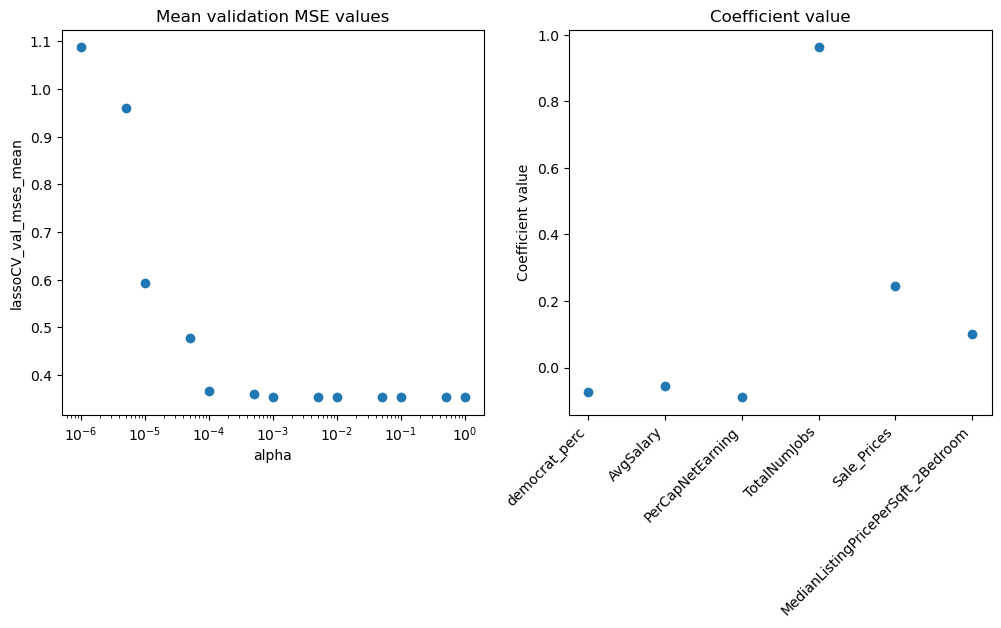

In [246]:
fig,axs = plt.subplots(1,2,figsize=(12, 5))

axs[0].scatter(a_list,np.mean(lassoCV_val_mses_mean,axis=1).tolist())
axs[0].set_xscale('log')
axs[0].set_xlabel('alpha')
axs[0].set_ylabel('lassoCV_val_mses_mean')
axs[0].set_title("Mean validation MSE values")

axs[1].scatter(np.linspace(1,lasso_drop.coef_.shape[0],lasso_drop.coef_.shape[0]),lasso_drop.coef_)
axs[1].set_xticks(np.arange(1,lasso_drop.coef_.shape[0]+1))
axs[1].set_xticklabels(X_train_drop.columns, rotation=45, ha='right')
axs[1].set_ylabel('Coefficient value')
axs[1].set_title("Coefficient value")

In [252]:
# Make predictions
y_train_predict = lasso_drop.predict(X_train_drop)
y_test_predict = lasso_drop.predict(X_test_drop)
train_mse = mean_squared_error(y_train,y_train_predict)
test_mse = mean_squared_error(y_test,y_test_predict)

print("The train MSE for the lasso_drop model is " + str(train_mse))
print("The test MSE for the lasso_drop model is " + str(test_mse))

# Modal diagnostics
train_score = lasso_drop.score(X_train_drop,y_train)
test_score = lasso_drop.score(X_test_drop,y_test)

print("The train R2 for the lasso_drop model is " + str(train_score))
print("The test R2 for the lasso_drop model is " + str(test_score))

The train MSE for the lasso_drop model is 0.12332244929251712
The test MSE for the lasso_drop model is 0.49650823032124797
The train R2 for the lasso_drop model is 0.8851872238590328
The test R2 for the lasso_drop model is 0.2872905398784682


## Build best model and train on the entire training set

In [175]:
# Retrain with best alpha and using all the training set
lasso_best = Lasso(alpha=best_alpha,max_iter=100000,random_state=26).fit(X_train,y_train)

# Modal diagnostics
best_train_score = lasso_best.score(X_train,y_train)
best_test_score = lasso_best.score(X_test,y_test)

print("The train R2 for the lasso model is " + str(best_train_score))
print("The test R2 for the lasso model is " + str(best_test_score))

The train R2 for the lasso model is 0.9020018719336064
The test R2 for the lasso model is 0.43637536851542347


In [176]:
key_coef = X_train.columns[lasso.coef_ != 0]
key_coef

Index(['democrat_perc', 'AvgSalary', 'PerCapNetEarning', 'PerCapNetIncome',
       'TotalNumJobs', 'Sale_Prices', 'MedianListingPricePerSqft_1Bedroom',
       'MedianListingPricePerSqft_2Bedroom',
       'MedianListingPricePerSqft_3Bedroom',
       'MedianListingPricePerSqft_4Bedroom',
       'MedianListingPricePerSqft_5BedroomOrMore'],
      dtype='object')